## MA5852 Assessment 2 - Cloud Computing
### Notebook 3 - Regularisation technique investigation

#### Part 0: Notebook preparation

In [4]:
%%sh
ls -l

#%%sh
#sudo chown ec2-user lost+found

#%%sh
#sudo chgrp ec2-user lost+found

#%%sh
#ls -l 

total 35060
-rw-rw-r-- 1 ec2-user ec2-user     5157 May 30 07:16 A2_baseline ANN model script.py
-rw-rw-r-- 1 ec2-user ec2-user     4559 May 31 05:15 A2_batch normalised ANN model script.py
-rw-rw-r-- 1 ec2-user ec2-user    85951 May 31 01:21 A2 Notebook 1.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 11921803 May 31 01:42 A2 Notebook 2.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 11921803 May 31 01:40 A2 Notebook 2_old.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 11921803 May 31 05:19 A2 Notebook 3.ipynb
-rw-rw-r-- 1 ec2-user ec2-user     5132 May 31 05:15 A2_regularised ANN model script.py
drwxrwxr-x 3 ec2-user ec2-user     4096 May 28 11:55 data
drwx------ 2 ec2-user ec2-user    16384 May 28 07:20 lost+found


In [15]:
# import necessary libraries
import boto3
import itertools
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import tensorflow as tf
import time

from tensorflow.keras import regularizers

from sagemaker.tensorflow import (
    TensorFlow,
    TensorFlowModel,
    TensorFlowPredictor)

from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score)

In [6]:
# define environment variables
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = "A2"
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, prefix)
training_input_path = "s3://{}/{}/training/training.npz".format(bucket, prefix)
validation_input_path = "s3://{}/{}/validation/validation.npz".format(bucket, prefix)
output_path = "s3://{}/{}/output".format(bucket, prefix)

print("SageMaker ver: " + sagemaker.__version__)
print("Tensorflow ver: " + tf.__version__)

SageMaker ver: 2.42.0
Tensorflow ver: 1.15.5


#### Part 1: Local mode

In [35]:
# set environment variables - file paths to data and for output
local_training_input_path = 'file://data/A2/training.npz'
local_validation_input_path = 'file://data/A2/validation.npz'
output = 'file:///tmp'

# model including options for setting early stopping, dropout and l1 or l2 regularisation
rt_estimator = TensorFlow(
    entry_point = 'A2_regularised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'local',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'epochs': 1, 'dropout': 0, 'early-stop': None, 'regularizer': 'l1_l2'},
    output_path = output)

# model including batch normalisation
bn_estimator = TensorFlow(
    entry_point = 'A2_batch normalised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'local',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'epochs': 1},
    output_path = output)

In [36]:
# test the first python script is working
inputs = {'training': local_training_input_path,
          'validation': local_validation_input_path}

rt_estimator.fit(inputs)

Creating 4puepvj9at-algo-1-jniiq ... 
Creating 4puepvj9at-algo-1-jniiq ... done
Attaching to 4puepvj9at-algo-1-jniiq
4puepvj9at-algo-1-jniiq | 2021-05-31 05:52:29,111 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
4puepvj9at-algo-1-jniiq | 2021-05-31 05:52:29,119 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
4puepvj9at-algo-1-jniiq | 2021-05-31 05:52:30,108 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
4puepvj9at-algo-1-jniiq | 2021-05-31 05:52:30,129 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
4puepvj9at-algo-1-jniiq | 2021-05-31 05:52:30,148 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
4puepvj9at-algo-1-jniiq | 2021-05-31 05:52:30,160 sagemaker-containers INFO     Invoking user script
4puepvj9at-algo-1-jniiq | 
4puepvj9at-algo-1-jniiq | Training Env:
4puepvj9at-algo-1-jniiq | 
4puepvj9at-algo-1-jniiq | {
4puepvj9at-al

4puepvj9at-algo-1-jniiq | Collecting keras-metrics
4puepvj9at-algo-1-jniiq |   Downloading keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)
4puepvj9at-algo-1-jniiq | Requirement already satisfied: Keras>=2.1.5 in /usr/local/lib/python3.6/dist-packages (from keras-metrics) (2.3.1)
4puepvj9at-algo-1-jniiq | Requirement already satisfied: h5py in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (2.10.0)
4puepvj9at-algo-1-jniiq | Requirement already satisfied: pyyaml in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (5.3.1)
4puepvj9at-algo-1-jniiq | Requirement already satisfied: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.14.0)
4puepvj9at-algo-1-jniiq | Requirement already satisfied: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.4.1)
4puepvj9at-algo-1-jniiq | Requirement already satisfied: keras-applications>=1.0.6 in /usr/local/lib/python3.6/di

In [10]:
# test the second python script is working
inputs = {'training': local_training_input_path,
          'validation': local_validation_input_path}

bn_estimator.fit(inputs)

Creating ywimm9w89d-algo-1-3kp7g ... 
Creating ywimm9w89d-algo-1-3kp7g ... done
Attaching to ywimm9w89d-algo-1-3kp7g
ywimm9w89d-algo-1-3kp7g | 2021-05-31 05:29:09,674 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
ywimm9w89d-algo-1-3kp7g | 2021-05-31 05:29:09,681 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
ywimm9w89d-algo-1-3kp7g | 2021-05-31 05:29:10,774 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
ywimm9w89d-algo-1-3kp7g | 2021-05-31 05:29:10,795 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
ywimm9w89d-algo-1-3kp7g | 2021-05-31 05:29:10,815 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
ywimm9w89d-algo-1-3kp7g | 2021-05-31 05:29:10,829 sagemaker-containers INFO     Invoking user script
ywimm9w89d-algo-1-3kp7g | 
ywimm9w89d-algo-1-3kp7g | Training Env:
ywimm9w89d-algo-1-3kp7g | 
ywimm9w89d-algo-1-3kp7g | {
ywimm9w89d-al

ywimm9w89d-algo-1-3kp7g | Collecting keras-metrics
ywimm9w89d-algo-1-3kp7g |   Downloading keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)
ywimm9w89d-algo-1-3kp7g | Requirement already satisfied: Keras>=2.1.5 in /usr/local/lib/python3.6/dist-packages (from keras-metrics) (2.3.1)
ywimm9w89d-algo-1-3kp7g | Requirement already satisfied: keras-preprocessing>=1.0.5 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.1.0)
ywimm9w89d-algo-1-3kp7g | Requirement already satisfied: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.4.1)
ywimm9w89d-algo-1-3kp7g | Requirement already satisfied: keras-applications>=1.0.6 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.0.8)
ywimm9w89d-algo-1-3kp7g | Requirement already satisfied: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.14.0)
ywimm9w89d-algo-1-3kp7g | Requirement already satisfied: pyyaml in /usr/l

ywimm9w89d-algo-1-3kp7g exited with code 0
Aborting on container exit...
===== Job Complete =====


#### Part 2: Sagemaker training

In [37]:
# reminder of the relevant S3 paths
print("Bucket: {}".format(bucket))
print("Tensorflow logs path: " + tensorflow_logs_path)
print("Training data location: " + training_input_path)
print("Validation data location: " + validation_input_path)
print("Output path: " + output_path)

Bucket: sagemaker-ap-southeast-2-987959606453
Tensorflow logs path: s3://sagemaker-ap-southeast-2-987959606453/A2/logs
Training data location: s3://sagemaker-ap-southeast-2-987959606453/A2/training/training.npz
Validation data location: s3://sagemaker-ap-southeast-2-987959606453/A2/validation/validation.npz
Output path: s3://sagemaker-ap-southeast-2-987959606453/A2/output


In [40]:
# configure the estimator for early stopping and train the model
rt_estimator = TensorFlow(
    entry_point = 'A2_regularised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'dropout': 0},
    output_path = output_path)

training_job_name = 'A2-earlystop-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

inputs = {'training': training_input_path,
          'validation': validation_input_path}

rt_estimator.fit(inputs, job_name=training_job_name)

2021-05-31 06:03:13 Starting - Starting the training job...
2021-05-31 06:03:36 Starting - Launching requested ML instancesProfilerReport-1622440981: InProgress
......
2021-05-31 06:04:37 Starting - Preparing the instances for training......
2021-05-31 06:05:37 Downloading - Downloading input data...
2021-05-31 06:06:02 Training - Downloading the training image...
2021-05-31 06:06:37 Training - Training image download completed. Training in progress.2021-05-31 06:06:28,168 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-31 06:06:28,178 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:06:29,934 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:06:29,957 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:06:29,976 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:06:29,988 sagem

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6317 - tn: 255.0000 - fn: 136.0000 - tp: 65.0000 - fp: 56.0000 - accuracy: 0.6250 - precision: 0.5372 - recall: 0.3234 - auc: 0.6595 - loss_1: 0.6317 - prc: 0.5478#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015   32/47638 [..............................] - ETA: 13s - loss: 0.6199 - tn: 18.0000 - fn: 7.0000 - tp: 6.0000 - fp: 1.0000 - accuracy: 0.7500 - precision: 0.8571 - recall: 0.4615 - auc: 0.7065 - loss_1: 0.6199 - prc: 0.6567#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010


2021-05-31 06:07:15 Uploading - Uploading generated training model
2021-05-31 06:07:15 Completed - Training job completed
#015   32/10208 [..............................] - ETA: 7:29 - loss: 0.5911 - tn: 16.0000 - fn: 6.0000 - tp: 5.0000 - fp: 5.0000 - accuracy: 0.6562 - precision: 0.5000 - recall: 0.4545 - auc: 0.7619 - loss_1: 0.5911 - prc: 0.5043#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

Training seconds: 101
Billable seconds: 101


In [41]:
# configure the estimator for l1 regularisation and train the model
rt_estimator = TensorFlow(
    entry_point = 'A2_regularised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'dropout': 0, 'early-stop': None, 'regularizer': 'l1'},
    output_path = output_path)

training_job_name = 'A2-l1reg-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

inputs = {'training': training_input_path,
          'validation': validation_input_path}

rt_estimator.fit(inputs, job_name=training_job_name)

2021-05-31 06:07:47 Starting - Starting the training job...
2021-05-31 06:08:10 Starting - Launching requested ML instancesProfilerReport-1622441255: InProgress
......
2021-05-31 06:09:12 Starting - Preparing the instances for training.........
2021-05-31 06:10:46 Downloading - Downloading input data...
2021-05-31 06:11:14 Training - Training image download completed. Training in progress..2021-05-31 06:11:20,930 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-31 06:11:20,937 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:11:22,302 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:11:22,321 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:11:22,341 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:11:22,359 sagemaker-containers INFO     Invoking user script

Training Env:


Model: "regularised_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
dense (Dense)                (None, 40)                4120      
_________________________________________________________________
p_re_lu (PReLU)              (None, 40)                40        
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                1804      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 44)                44        
_________________________________________________________________
dropout_1 (Dropout)          (None, 44)          

#015  512/47638 [..............................] - ETA: 1s - loss: 0.7457 - tn: 306.0000 - fn: 206.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.5977 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6742 - prc: 0.4023#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  512/47638 [..............................] - ETA: 1s - loss: 0.7324 - tn: 320.0000 - fn: 192.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.6250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6648 - prc: 0.3750#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  512/47638 [..............................] - ETA: 1s - loss: 0.7542 - tn: 289.0000 - fn: 223.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.5645 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6865 - prc: 0.4355#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  512/47638 [..............................] - ETA: 1s - loss: 0.7462 - tn: 298.0000 - fn: 214.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.5820 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6796 - prc: 0.4180#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01533088/47638 [===================>..........] - ETA: 1s - loss: 0.7435 - tn: 19452.0000 - fn: 13636.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.5879 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6777 - prc: 0.4121#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0


2021-05-31 06:12:31 Uploading - Uploading generated training model
2021-05-31 06:12:31 Completed - Training job completed
Training seconds: 105
Billable seconds: 105


In [42]:
# configure the estimator for l2 regularisation and train the model
rt_estimator = TensorFlow(
    entry_point = 'A2_regularised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'dropout': 0, 'early-stop': None, 'regularizer': 'l2'},
    output_path = output_path)

training_job_name = 'A2-l2reg-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

inputs = {'training': training_input_path,
          'validation': validation_input_path}

rt_estimator.fit(inputs, job_name=training_job_name)

2021-05-31 06:15:27 Starting - Starting the training job...
2021-05-31 06:15:29 Starting - Launching requested ML instancesProfilerReport-1622441715: InProgress
......
2021-05-31 06:16:52 Starting - Preparing the instances for training......
2021-05-31 06:17:52 Downloading - Downloading input data...
2021-05-31 06:18:12 Training - Downloading the training image..
2021-05-31 06:18:52 Training - Training image download completed. Training in progress.2021-05-31 06:18:41,081 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-31 06:18:41,089 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:18:42,522 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:18:42,542 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:18:42,562 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:18:42,575 sagema

#015  512/47638 [..............................] - ETA: 4:46 - loss: 1.7323 - tn: 213.0000 - fn: 183.0000 - tp: 49.0000 - fp: 67.0000 - accuracy: 0.5117 - precision: 0.4224 - recall: 0.2112 - auc: 0.4571 - loss_1: 0.7198 - prc: 0.4187#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6467 - tn: 262.0000 - fn: 159.0000 - tp: 58.0000 - fp: 33.0000 - accuracy: 0.6250 - precision: 0.6374 - recall: 0.2673 - auc: 0.6692 - loss_1: 0.6395 - prc: 0.5935#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6649 - tn: 242.0000 - fn: 150.0000 - tp: 62.0000 - fp: 58.0000 - accuracy: 0.5938 - precision: 0.5167 - recall: 0.2925 - auc: 0.6112 - loss_1: 0.6591 - prc: 0.5328#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6383 - tn: 249.0000 - fn: 136.0000 - tp: 77.0000 - fp: 50.0000 - accuracy: 0.6367 - precision: 0.6063 - recall: 0.3615 - auc: 0.6801 - loss_1: 0.6334 - prc: 0.5800#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015   32/47638 [..............................] - ETA: 14s - loss: 0.6687 - tn: 17.0000 - fn: 7.0000 - tp: 6.0000 - fp: 2.0000 - accuracy: 0.7188 - precision: 0.7500 - recall: 0.4615 - auc: 0.6093 - loss_1: 0.6638 - prc: 0.6713#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010


2021-05-31 06:19:56 Uploading - Uploading generated training model
2021-05-31 06:19:56 Completed - Training job completed
#015   32/10208 [..............................] - ETA: 7:51 - loss: 0.6357 - tn: 18.0000 - fn: 8.0000 - tp: 3.0000 - fp: 3.0000 - accuracy: 0.6562 - precision: 0.5000 - recall: 0.2727 - auc: 0.6948 - loss_1: 0.6308 - prc: 0.4548#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

Training seconds: 129
Billable seconds: 129


In [43]:
# configure the estimator for l1_l2 regularisation and train the model
rt_estimator = TensorFlow(
    entry_point = 'A2_regularised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'dropout': 0, 'early-stop': None, 'regularizer': 'l1_l2'},
    output_path = output_path)

training_job_name = 'A2-l1l2reg-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

inputs = {'training': training_input_path,
          'validation': validation_input_path}

rt_estimator.fit(inputs, job_name=training_job_name)

2021-05-31 06:20:22 Starting - Starting the training job...
2021-05-31 06:20:45 Starting - Launching requested ML instancesProfilerReport-1622442010: InProgress
......
2021-05-31 06:21:45 Starting - Preparing the instances for training......
2021-05-31 06:22:49 Downloading - Downloading input data...
2021-05-31 06:23:14 Training - Downloading the training image...
2021-05-31 06:23:46 Training - Training image download completed. Training in progress.2021-05-31 06:23:41,163 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-31 06:23:41,171 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:23:42,549 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:23:42,568 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:23:42,587 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:23:42,601 sagem

ERROR:root:'NoneType' object has no attribute 'write'
#015  512/47638 [..............................] - ETA: 4:30 - loss: 8.1886 - tn: 242.0000 - fn: 172.0000 - tp: 33.0000 - fp: 65.0000 - accuracy: 0.5371 - precision: 0.3367 - recall: 0.1610 - auc: 0.4942 - loss_1: 0.6990 - prc: 0.3908#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.7384 - tn: 318.0000 - fn: 194.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.6211 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6649 - prc: 0.3789#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0


2021-05-31 06:24:18 Uploading - Uploading generated training model#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01526816/47638 [===============>..............] - ETA: 2s - loss: 0.7469 - tn: 15794.0000 - fn: 11022.0000 - tp: 0.0000e+00 - fp: 0.0000e+00 - accuracy: 0.5890 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - loss_1: 0.6773 - prc: 0.4110#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01


2021-05-31 06:24:46 Completed - Training job completed
ProfilerReport-1622442010: NoIssuesFound
Training seconds: 97
Billable seconds: 97


In [44]:
# configure the estimator for 50% dropout and train the model
rt_estimator = TensorFlow(
    entry_point = 'A2_regularised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'dropout': 0.5, 'early-stop': None},
    output_path = output_path)

training_job_name = 'A2-dropout-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

inputs = {'training': training_input_path,
          'validation': validation_input_path}

rt_estimator.fit(inputs, job_name=training_job_name)

2021-05-31 06:25:18 Starting - Starting the training job...
2021-05-31 06:25:41 Starting - Launching requested ML instancesProfilerReport-1622442306: InProgress
......
2021-05-31 06:26:41 Starting - Preparing the instances for training......
2021-05-31 06:27:41 Downloading - Downloading input data...
2021-05-31 06:28:15 Training - Training image download completed. Training in progress..2021-05-31 06:28:20,663 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-31 06:28:20,671 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:28:21,976 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:28:21,995 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:28:22,015 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:28:22,028 sagemaker-containers INFO     Invoking user script

Training Env:

{


#015  512/47638 [..............................] - ETA: 2s - loss: 0.6353 - tn: 270.0000 - fn: 140.0000 - tp: 62.0000 - fp: 40.0000 - accuracy: 0.6484 - precision: 0.6078 - recall: 0.3069 - auc: 0.6474 - loss_1: 0.6353 - prc: 0.5591#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6511 - tn: 251.0000 - fn: 135.0000 - tp: 65.0000 - fp: 61.0000 - accuracy: 0.6172 - precision: 0.5159 - recall: 0.3250 - auc: 0.6365 - loss_1: 0.6511 - prc: 0.4842#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6099 - tn: 274.0000 - fn: 123.0000 - tp: 68.0000 - fp: 47.0000 - accuracy: 0.6680 - precision: 0.5913 - recall: 0.3560 - auc: 0.6777 - loss_1: 0.6099 - prc: 0.5748#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6498 - tn: 269.0000 - fn: 147.0000 - tp: 52.0000 - fp: 44.0000 - accuracy: 0.6270 - precision: 0.5417 - recall: 0.2613 - auc: 0.6141 - loss_1: 0.6498 - prc: 0.4993#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015   32/10208 [..............................] - ETA: 7:10 - loss: 0.5867 - tn: 18.0000 - fn: 6.0000 - tp: 5.0000 - fp: 3.0000 - accuracy: 0.7188 - precision: 0.6250 - recall: 0.4545 - auc: 0.7900 - loss_1: 0.5867 - prc: 0.5580#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01


2021-05-31 06:29:42 Uploading - Uploading generated training model
2021-05-31 06:29:42 Completed - Training job completed
Training seconds: 121
Billable seconds: 121


In [45]:
# train the model with batch normalised layers
bn_estimator = TensorFlow(
    entry_point = 'A2_batch normalised ANN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'local',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    output_path = output)

training_job_name = 'A2-bn-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

inputs = {'training': training_input_path,
          'validation': validation_input_path}

rt_estimator.fit(inputs, job_name=training_job_name)

2021-05-31 06:30:13 Starting - Starting the training job...
2021-05-31 06:30:36 Starting - Launching requested ML instancesProfilerReport-1622442602: InProgress
......
2021-05-31 06:31:36 Starting - Preparing the instances for training......
2021-05-31 06:32:37 Downloading - Downloading input data...
2021-05-31 06:33:11 Training - Training image download completed. Training in progress...2021-05-31 06:33:17,840 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-31 06:33:17,848 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:33:19,073 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:33:19,092 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:33:19,110 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-31 06:33:19,124 sagemaker-containers INFO     Invoking user script

Training Env:

{

#015  512/47638 [..............................] - ETA: 4:46 - loss: 0.8115 - tn: 174.0000 - fn: 117.0000 - tp: 101.0000 - fp: 120.0000 - accuracy: 0.5371 - precision: 0.4570 - recall: 0.4633 - auc: 0.5036 - loss_1: 0.8115 - prc: 0.4392#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6311 - tn: 272.0000 - fn: 154.0000 - tp: 55.0000 - fp: 31.0000 - accuracy: 0.6387 - precision: 0.6395 - recall: 0.2632 - auc: 0.6777 - loss_1: 0.6311 - prc: 0.5853#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6534 - tn: 276.0000 - fn: 156.0000 - tp: 39.0000 - fp: 41.0000 - accuracy: 0.6152 - precision: 0.4875 - recall: 0.2000 - auc: 0.6038 - loss_1: 0.6534 - prc: 0.4632#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  512/47638 [..............................] - ETA: 1s - loss: 0.6354 - tn: 258.0000 - fn: 138.0000 - tp: 64.0000 - fp: 52.0000 - accuracy: 0.6289 - precision: 0.5517 - recall: 0.3168 - auc: 0.6469 - loss_1: 0.6354 - prc: 0.5444#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01536384/47638 [=====================>........] - ETA: 1s - loss: 0.6271 - tn: 18591.0000 - fn: 9849.0000 - tp: 5135.0000 - fp: 2809.0000 - accuracy: 0.6521 - precision: 0.6464 - recall: 0.3427 - auc: 0.6828 - loss_1: 0.6271 - prc: 0.6039#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#


2021-05-31 06:34:37 Uploading - Uploading generated training model
2021-05-31 06:34:37 Completed - Training job completed
ProfilerReport-1622442602: NoIssuesFound
Training seconds: 119
Billable seconds: 119


#### Part 3: Model deployment

In [57]:
# configure and deploy model endpoints for the regularised models
#reg_model_name='A2-earlystop-job-2021-05-31-06-03-01'
#reg_model_name='A2-l1reg-job-2021-05-31-06-07-35'
#reg_model_name='A2-l2reg-job-2021-05-31-06-15-15'
reg_model_name='A2-l1l2reg-job-2021-05-31-06-20-10'
#reg_model_name='A2-dropout-job-2021-05-31-06-25-06'
#reg_model_name='A2-bn-job-2021-05-31-06-30-02'

reg_model_uri="s3://{}/{}/output/{}/output/model.tar.gz".format(bucket, prefix, reg_model_name)
reg_endpoint_name = reg_model_name + '-ep'

reg_model = TensorFlowModel(
    model_data=reg_model_uri,
    role=role,
    framework_version='2.1.0')

reg_model_predictor = reg_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name=reg_endpoint_name)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

In [47]:
# load in test data
test_data = np.load("./data/A2/testing.npz")
X_test = test_data['features']
y_test = test_data['labels']

In [58]:
# make predictions
predictions = np.array(reg_model_predictor.predict(X_test)["predictions"])
y_pred = np.where(predictions > 0.5, 1, 0)

In [59]:
# calculate metrics
accuracy_metric = accuracy_score(y_test, y_pred)
precision_metric = precision_score(y_test, y_pred)
recall_metric = recall_score(y_test, y_pred)
auc_metric = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, predictions)
auprc_metric = auc(recall, precision)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity_metric = tn/(tn+fp)
balanced_accuracy_metric = balanced_accuracy_score(y_test, y_pred)
f1_metric = f1_score(y_test, y_pred)

print("Accuracy: {}".format(round(accuracy_metric,4)))
print("Precision: {}".format(round(precision_metric,4)))
print("Recall: {}".format(round(recall_metric,4)))
print("AUC: {}".format(round(auc_metric,4)))
print("AUPRC: {}".format(round(auprc_metric,4)))

print("Specificity: {}".format(round(specificity_metric,4)))
print("Balanced accuracy: {}".format(round(balanced_accuracy_metric,4)))
print("F1 score: {}".format(round(f1_metric,4)))

Accuracy: 0.5886
Precision: 0.0
Recall: 0.0
AUC: 0.5
AUPRC: 0.4342
Specificity: 1.0
Balanced accuracy: 0.5
F1 score: 0.0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


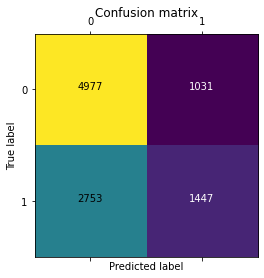

In [50]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] < thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [56]:
# to avoid incurring unexpected extra charges on the account, delete the endpoints
reg_model_predictor.delete_endpoint()